In [1]:
import pydicom
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut


[2025-04-03 15:31:41,630] DEBUG: DICOM-файл успешно загружен
[2025-04-03 15:31:41,630] DEBUG: DICOM-файл успешно загружен
[2025-04-03 15:31:42,911] DEBUG: Исходный массив: shape=(71, 1024, 1024), dtype=uint16
[2025-04-03 15:31:42,911] DEBUG: Исходный массив: shape=(71, 1024, 1024), dtype=uint16
[2025-04-03 15:31:42,912] DEBUG: WindowCenter: 1800, WindowWidth: 2200
[2025-04-03 15:31:42,912] DEBUG: WindowCenter: 1800, WindowWidth: 2200
[2025-04-03 15:31:42,934] DEBUG: Обработан кадр 1/71, min=0, max=166
[2025-04-03 15:31:42,934] DEBUG: Обработан кадр 1/71, min=0, max=166
[2025-04-03 15:31:42,949] DEBUG: Обработан кадр 2/71, min=9, max=242
[2025-04-03 15:31:42,949] DEBUG: Обработан кадр 2/71, min=9, max=242
[2025-04-03 15:31:42,949] DEBUG: Обработан кадр 3/71, min=0, max=207
[2025-04-03 15:31:42,949] DEBUG: Обработан кадр 3/71, min=0, max=207
[2025-04-03 15:31:42,968] DEBUG: Обработан кадр 4/71, min=0, max=203
[2025-04-03 15:31:42,968] DEBUG: Обработан кадр 4/71, min=0, max=203
[2025-04-0

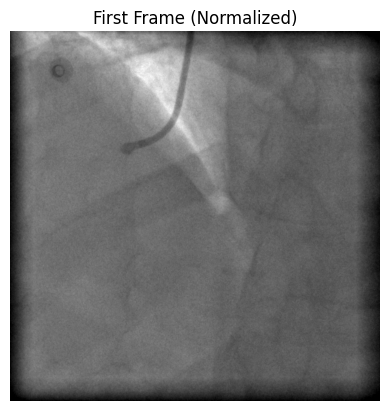

Проверка: shape=(71, 1024, 1024), dtype=uint8


In [ ]:
import pydicom
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import logging
import matplotlib.pyplot as plt

# Настройка логирования
logger = logging.getLogger("DICOMProcessor")
logger.setLevel(logging.DEBUG)
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s: %(message)s"))
logger.addHandler(console_handler)

# Загрузка исходного DICOM-файла
input_file = 'Dicoms/1.3.12.2.1107.5.4.5.44033.30000019072205491532800000015.1024.dcm'
try:
    dcm = pydicom.dcmread(input_file, force=True)
    logger.debug("DICOM-файл успешно загружен")
except Exception as e:
    logger.error(f"Ошибка при загрузке файла: {e}")
    raise

# Проверка наличия пиксельных данных
if 'PixelData' not in dcm:
    logger.error("DICOM-файл не содержит пиксельных данных")
    raise ValueError("DICOM-файл не содержит пиксельных данных")

# Извлечение пиксельных данных
pixel_array = dcm.pixel_array
logger.debug(f"Исходный массив: shape={pixel_array.shape}, dtype={pixel_array.dtype}")

# Проверка параметров VOI LUT
if 'WindowCenter' in dcm and 'WindowWidth' in dcm:
    window_center = dcm.WindowCenter
    window_width = dcm.WindowWidth
    logger.debug(f"WindowCenter: {window_center}, WindowWidth: {window_width}")
else:
    window_center = None
    window_width = None
    logger.debug("Параметры VOI LUT отсутствуют")

# Функция для применения VOI LUT или нормализации к одному кадру
def normalize_frame(frame, window_center=None, window_width=None):
    # Если есть параметры VOI LUT, используем их
    if window_center is not None and window_width is not None:
        # Преобразуем параметры в список, если они скалярные
        if not isinstance(window_center, (list, tuple)):
            window_center = [window_center]
        if not isinstance(window_width, (list, tuple)):
            window_width = [window_width]
        
        # Берем первые значения (для простоты)
        wc = window_center[0]
        ww = window_width[0]
        
        # Применяем оконное преобразование вручную
        frame_min = wc - ww / 2
        frame_max = wc + ww / 2
        frame_normalized = np.clip(frame, frame_min, frame_max)
        frame_normalized = (frame_normalized - frame_min) / (frame_max - frame_min) * 255.0
    else:
        # Ручная нормализация на основе значений кадра
        if np.max(frame) == np.min(frame):
            logger.warning("Кадр содержит одинаковые значения, нормализация невозможна")
            return np.zeros_like(frame, dtype=np.uint8)
        frame_normalized = (frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255.0
    
    return frame_normalized.astype(np.uint8)

# Обработка всех кадров
if len(pixel_array.shape) == 3:  # Многокадровый DICOM
    n_slices = pixel_array.shape[0]
    processed_frames = np.zeros_like(pixel_array, dtype=np.uint8)
    
    for i in range(n_slices):
        frame = pixel_array[i]
        processed_frames[i] = normalize_frame(frame, window_center, window_width)
        logger.debug(f"Обработан кадр {i+1}/{n_slices}, min={processed_frames[i].min()}, max={processed_frames[i].max()}")
else:  # Однокадровый DICOM
    processed_frames = normalize_frame(pixel_array, window_center, window_width)
    logger.debug(f"Обработан однокадровый DICOM, min={processed_frames.min()}, max={processed_frames.max()}")

# Обновление метаданных
dcm.BitsAllocated = 8
dcm.BitsStored = 8
dcm.HighBit = 7
dcm.PixelRepresentation = 0  # Unsigned integer
dcm.SamplesPerPixel = 1
dcm.PhotometricInterpretation = 'MONOCHROME2'

# Указание количества кадров и размеров
if len(processed_frames.shape) == 3:
    dcm.NumberOfFrames = str(processed_frames.shape[0])
    dcm.Rows, dcm.Columns = processed_frames.shape[1], processed_frames.shape[2]
else:
    dcm.Rows, dcm.Columns = processed_frames.shape

# Установка TransferSyntaxUID для несжатых данных
if not hasattr(dcm, 'file_meta') or dcm.file_meta is None:
    dcm.file_meta = pydicom.dataset.FileMetaDataset()
dcm.file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'  # Explicit VR Little Endian
logger.debug(f"Установлен TransferSyntaxUID: {dcm.file_meta.TransferSyntaxUID}")

# Обновление PixelData
dcm.PixelData = processed_frames.tobytes()

# Сохранение нового DICOM-файла
output_file = 'output_normalized_multiframe_dicom.dcm'
try:
    dcm.save_as(output_file)
    logger.info(f"Сохранен новый DICOM-файл: {output_file}")
except Exception as e:
    logger.error(f"Ошибка при сохранении файла: {e}")
    raise

# Проверка результата: отображение первого кадра
if len(processed_frames.shape) == 3:
    plt.imshow(processed_frames[0], cmap='gray')
else:
    plt.imshow(processed_frames, cmap='gray')
plt.title("First Frame (Normalized)")
plt.axis('off')
plt.show()

# Проверка сохраненного файла
dcm_check = pydicom.dcmread(output_file)
print(f"Проверка: shape={dcm_check.pixel_array.shape}, dtype={dcm_check.pixel_array.dtype}")